# DAT200 CA3 2023

Kaggle username: aarondeleyos 

### Imports

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Reading data

In [2]:
# Load in the training data.
training = pd.read_csv(r'assets\train.csv')

### Data exploration and visualisation

In [3]:
training = training.drop(training.columns[0], axis=1) # Removing the 1st column for convenience
training_target = training.iloc[:, -1] # Seperate the target data from the testing data

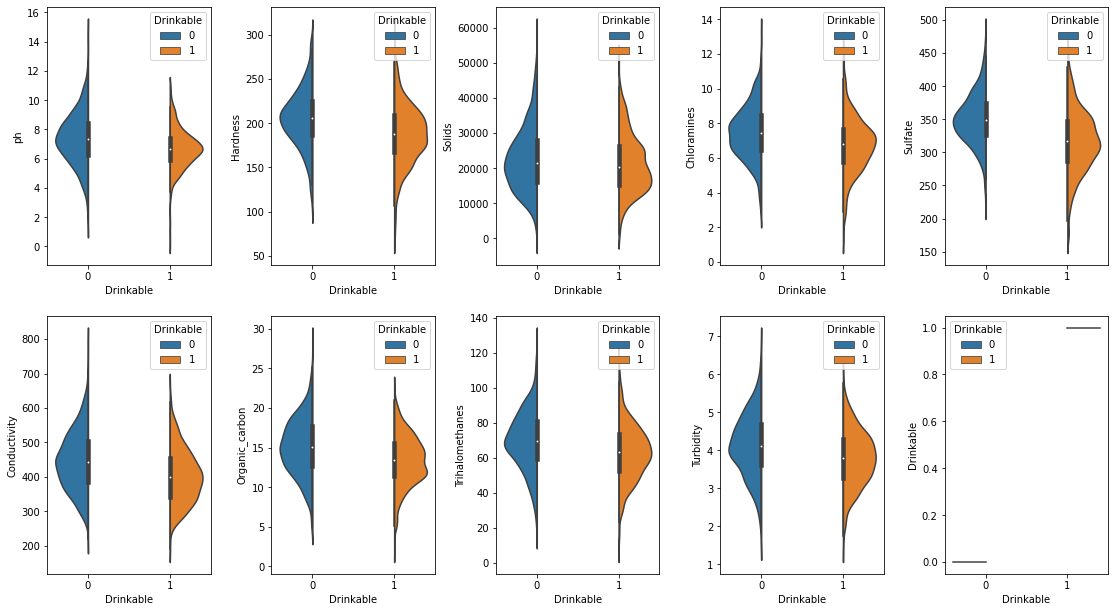

In [4]:
# Violin plot to get an overview of the different features which are seperated by the class label
fig_violin, ax_violin = plt.subplots(nrows=2, ncols=5, figsize=(16, 9))
plt.tight_layout(pad=3.0)

i = 0
for row in range(2):
    for col in range(5):
        sns.violinplot(ax=ax_violin[row, col], data=training, x='Drinkable', y=training.columns[i], 
                       hue='Drinkable', split=True)
        i += 1
        
plt.show()

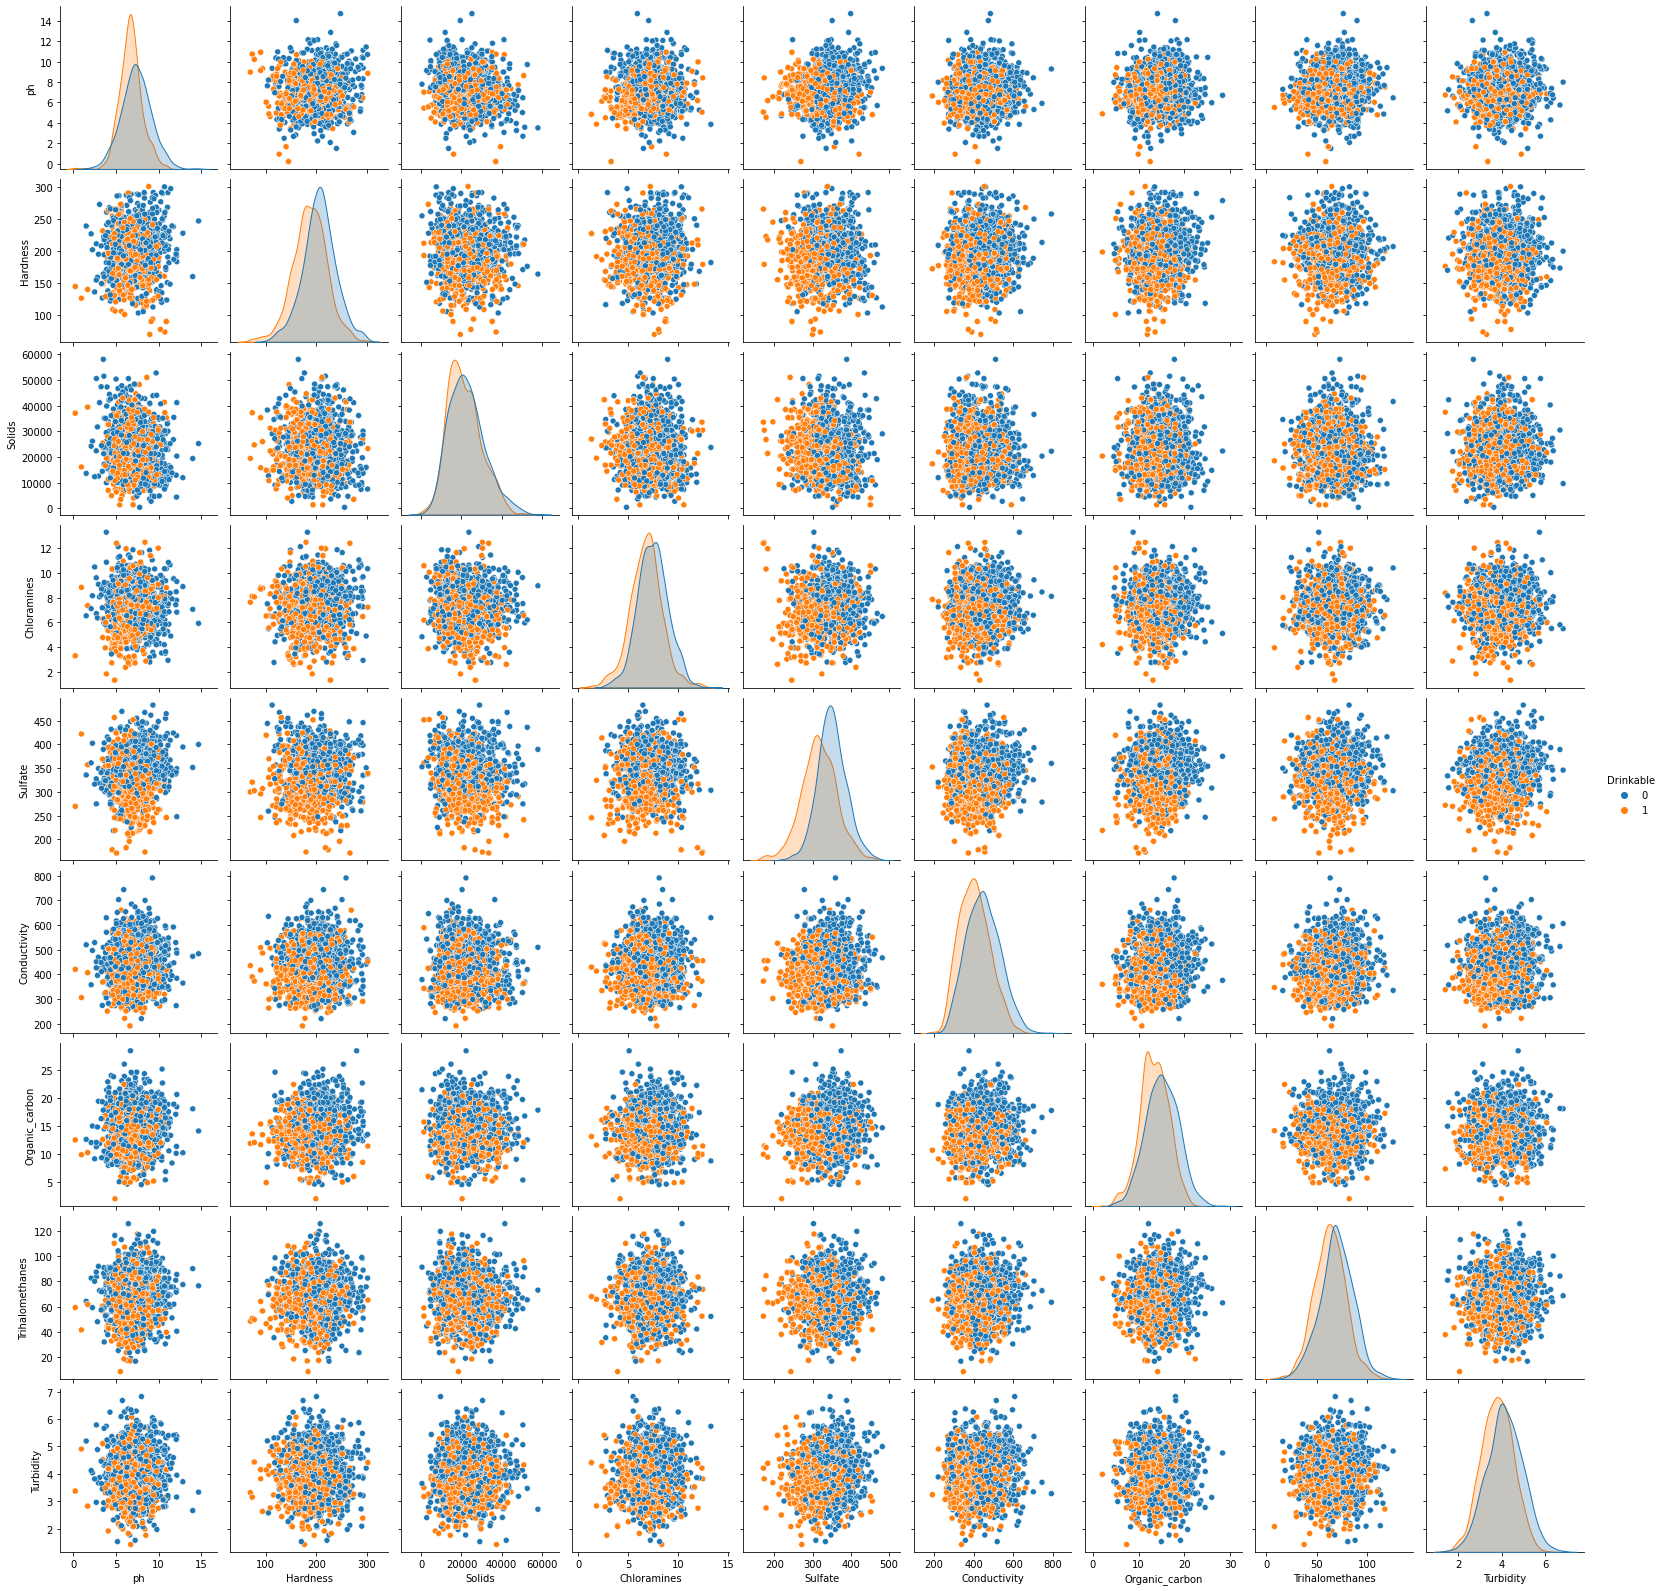

In [5]:
# Pair plot to get an overview of the data, seperated by the class variable
sns.pairplot(data=training, hue='Drinkable')
plt.show()

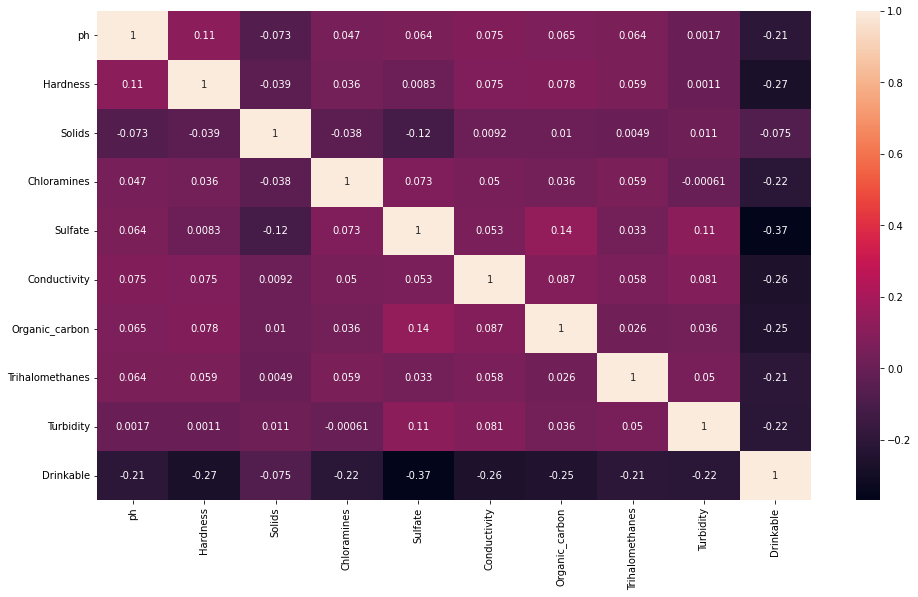

In [6]:
# Correlation matrix to see how the different features are correlated to each other
correlation_matrix = training.corr()
fig_corr, ax_corr = plt.subplots(figsize=(16, 9))
sns.heatmap(data=correlation_matrix, annot=True, ax=ax_corr)
plt.show()

### Data cleaning

In [7]:
# Remove all outliers for drinkable water
cleaned_data = training.copy()
col_names = list(cleaned_data.columns[:-1]) # Retrieve names of the columns except for the last class column

print(f'Shape of dataset before removing outliers for drinkable water: {cleaned_data.shape}')
for column in col_names:
    # I remove the outliers of the data by calculating the IQR, 
    # 25th and 75th percentile and use them to remove outliers for every feature.
    q1 = cleaned_data[column].quantile(.25)
    q3 = cleaned_data[column].quantile(.75)
    iqr = q3 - q1
    bot_outliers = q1 - 1.5 * iqr
    top_outliers = q3 + 1.5 * iqr
    cleaned_data.drop(cleaned_data[(cleaned_data[column] > top_outliers)].index, inplace=True)
    cleaned_data.drop(cleaned_data[(cleaned_data[column] < bot_outliers)].index, inplace=True)
print(f'Shape of dataset after removing outliers for drinkable water: {cleaned_data.shape}')

target = cleaned_data.iloc[:, -1] # retrieve the new the target values of the training data

Shape of dataset before removing outliers for drinkable water: (2040, 10)
Shape of dataset after removing outliers for drinkable water: (1797, 10)


### Data exploration after cleaning

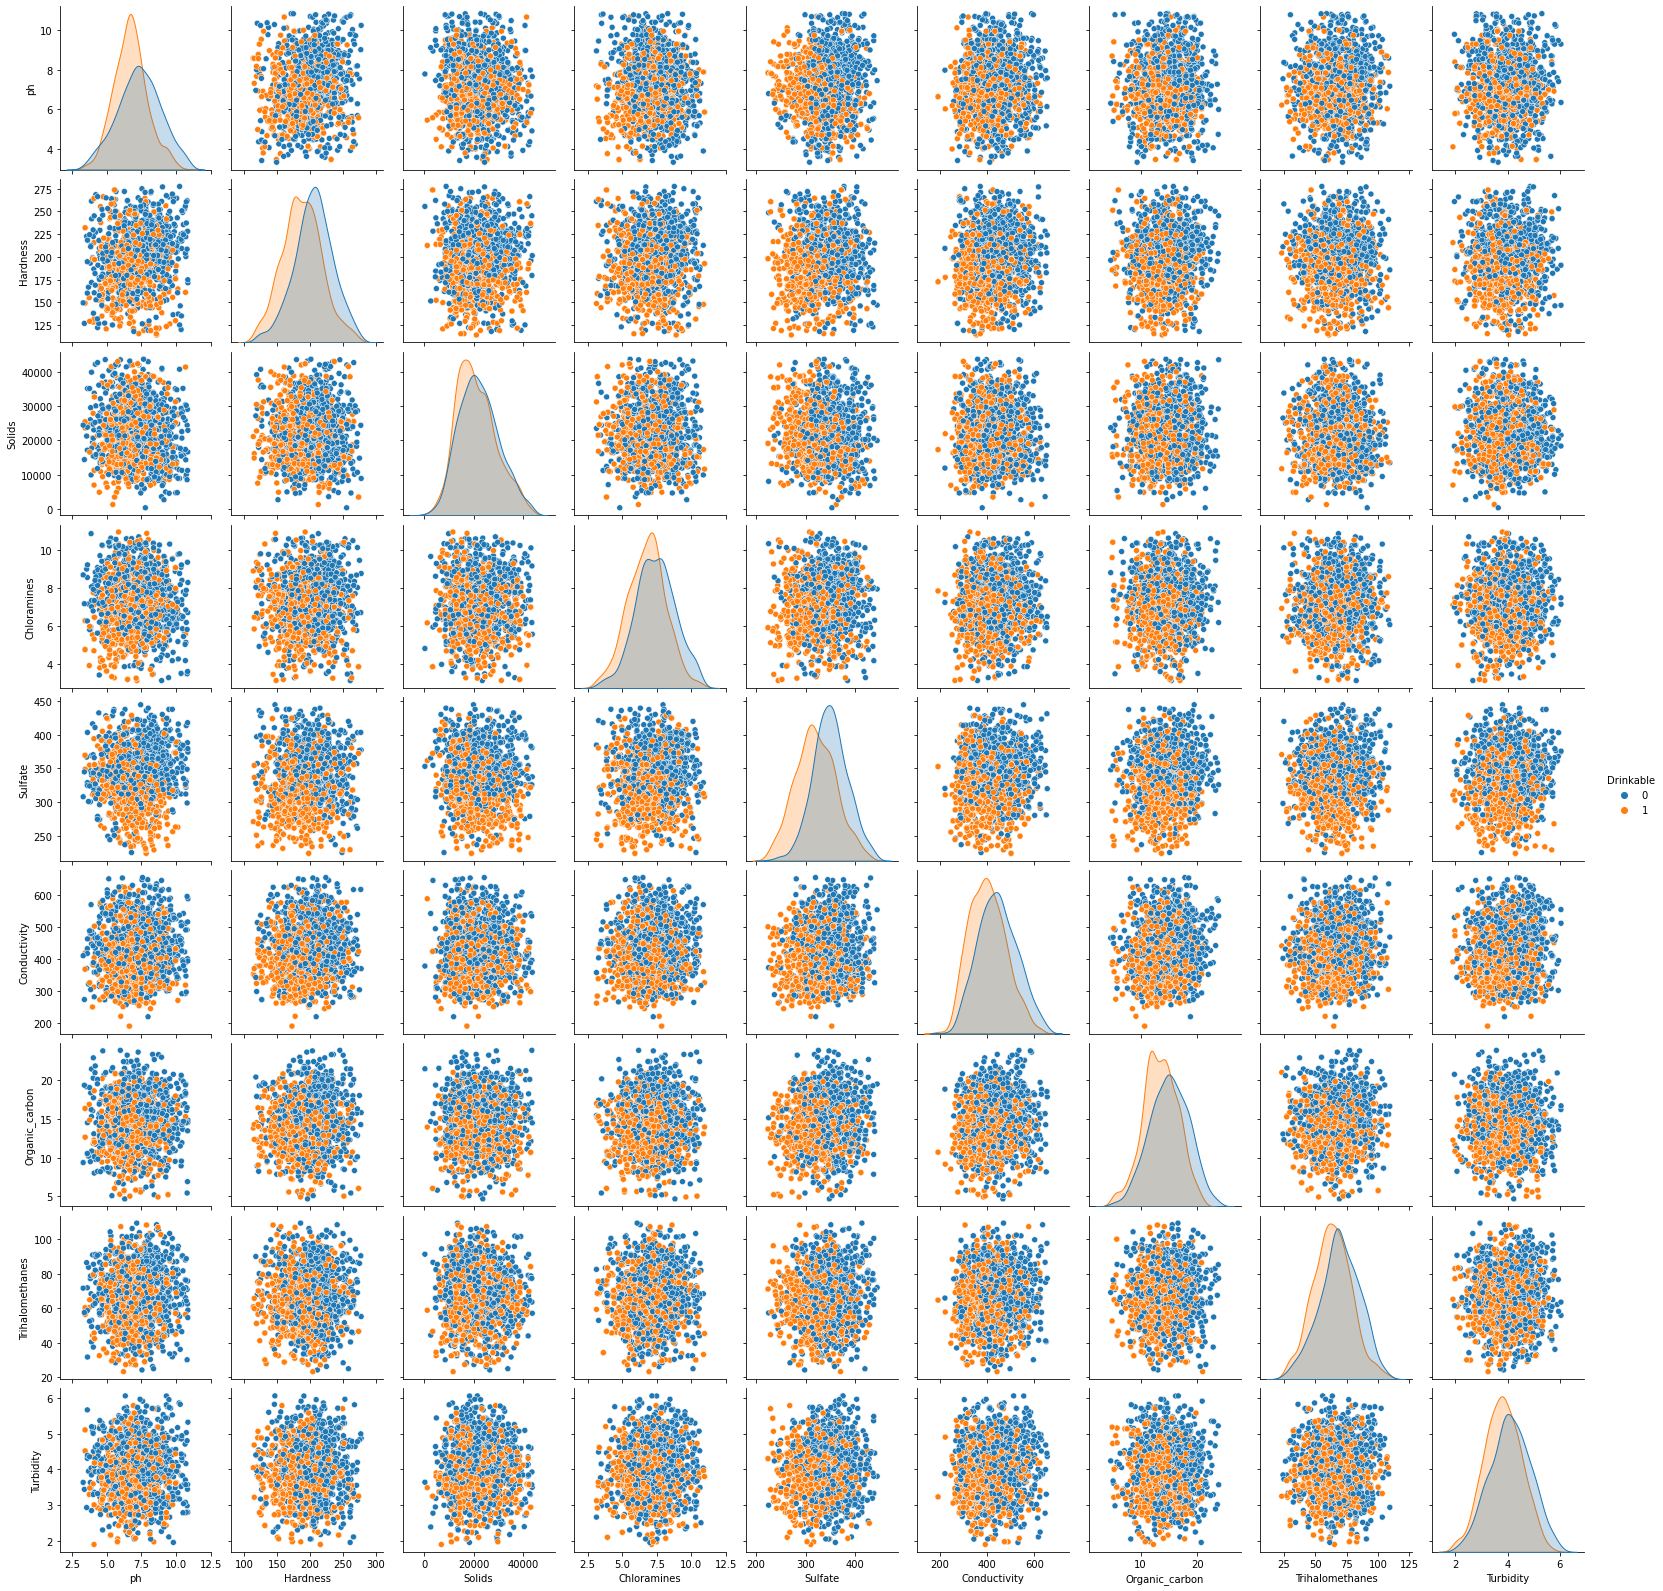

In [8]:
# Pair plot to get an overview of the data after removing the outliers
sns.pairplot(data=cleaned_data, hue='Drinkable')
plt.show()

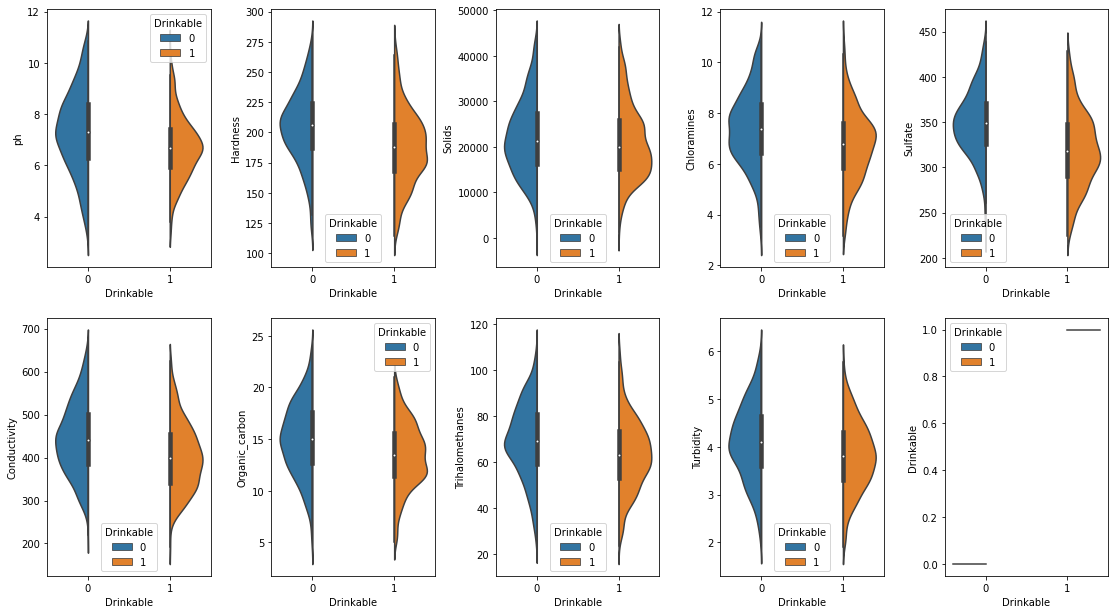

In [9]:
# Violin plot to get an overview of the data after removing the outliers
fig_violin, ax_violin = plt.subplots(nrows=2, ncols=5, figsize=(16, 9))
plt.tight_layout(pad=3.0)

i = 0
for row in range(2):
    for col in range(5):
        sns.violinplot(ax=ax_violin[row, col], data=cleaned_data, x='Drinkable', y=cleaned_data.columns[i], 
                       hue='Drinkable', split=True)
        i += 1
        
plt.show()

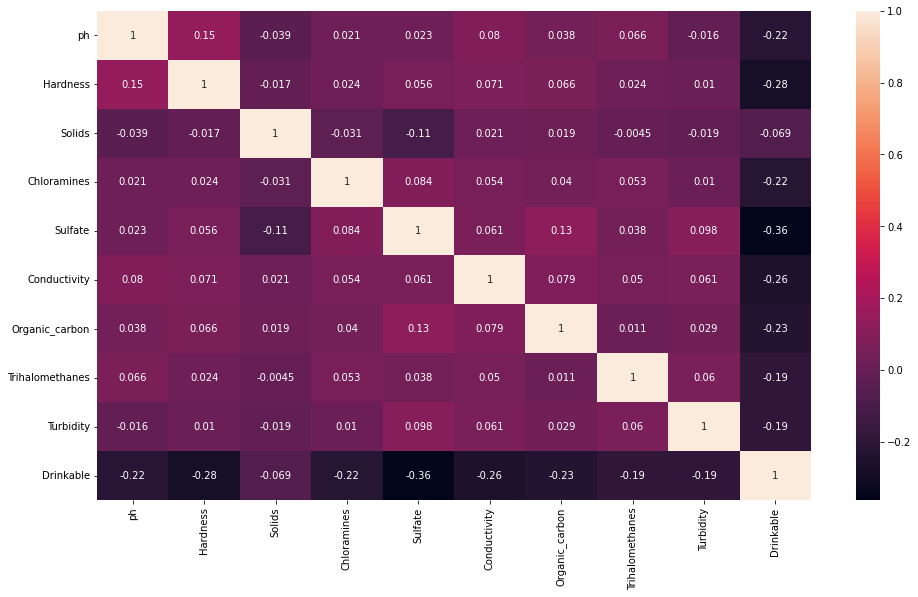

In [10]:
# Correlation matrix to get an overview of the data after removing the outliers
# We observe that the correlation between features has barely changed.
correlation_matrix = cleaned_data.corr()
fig_corr, ax_corr = plt.subplots(figsize=(16, 9))
sns.heatmap(data=correlation_matrix, annot=True, ax=ax_corr)
plt.show()

### Data preprocessing

In [11]:
# PCA
# I wanted to see if we could use the principal components of the features
# to train the model, however the results weren't sufficient for me to use them
# any further.

X_train, X_test, y_train, y_test = train_test_split(cleaned_data.iloc[:, :-1], target, test_size=0.3, 
                                                    stratify=target, random_state=24624624)

sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
pca = PCA(n_components=9)

X_train_PCA = pca.fit_transform(X_train_std)
X_test_PCA = pca.transform(X_test_std)

explVars = pca.explained_variance_ratio_
print(explVars)
print(np.cumsum(explVars))

[0.15957688 0.12306577 0.11975944 0.11433948 0.10893179 0.10196344
 0.09600113 0.09114018 0.08522188]
[0.15957688 0.28264265 0.40240209 0.51674157 0.62567336 0.7276368
 0.82363793 0.91477812 1.        ]


In [12]:
# Assesing feature importance with random forests
# I wanted to see if there we're any features that stood out more than others.
# However, when testing for just the features selected the results given wasn't
# what I had in mind.

feat_labels = np.array(cleaned_data[:-1].columns)

forest_features = RandomForestClassifier(criterion='gini', n_estimators=200, random_state=200,
                                        n_jobs=-1)

forest_features.fit(cleaned_data.iloc[:, :-1], target)
importances = forest_features.feature_importances_

sfm = SelectFromModel(forest_features, prefit=True)
X_selected = sfm.transform(X_train)
indices = np.argsort(importances)[::-1]

print(X_selected.shape[1])

for f in range(X_selected.shape[1]):
    print(f'{f})',importances[indices[f]], feat_labels[indices[f]])

3
0) 0.18860331362762373 Sulfate
1) 0.13792953874331976 ph
2) 0.13498827948882341 Hardness


c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


### Modelling

##### Random forest

In [49]:
training_accuracy = []
test_accuracy = []s
num_trees = list(range(100, 500 + 1, 5))
state = 404923 

# A for loop which increases in number of trees the model will run with
for trees in num_trees:
    # Split the data into a training and test set.
    X_train, X_test, y_train, y_test = train_test_split(cleaned_data.iloc[:, :-1], 
                                                        target, test_size=0.3, stratify=target, 
                                                        random_state=state)
    
    # Initially I tried with gini impurity, but with entropy as impurity measureme 
    # and increasing the max features to 4 yielded the best results for me in terms 
    # of test accuarcy on the training set. This was just a matter of trying different
    # combinations of things until I got satisfied with the results.
    forest = RandomForestClassifier(criterion='entropy', n_estimators=trees, random_state=state,
                                    n_jobs=-1, max_features=4)
    forest.fit(X_train, y_train)
    train_score = forest.score(X_train, y_train)
    test_score = forest.score(X_test, y_test)
    training_accuracy.append(train_score)
    test_accuracy.append(test_score)

    # Print current accuracy measurements for the current number of trees
    print(f'\n*** Number of trees: {trees}')
    print(f'Training accuracy: {train_score:.5f}')
    print(f'Test accuracy: {test_score:.5f}')


*** Number of trees: 100
Training accuracy: 1.00000
Test accuracy: 0.89259

*** Number of trees: 105
Training accuracy: 1.00000
Test accuracy: 0.89444

*** Number of trees: 110
Training accuracy: 1.00000
Test accuracy: 0.89630

*** Number of trees: 115
Training accuracy: 1.00000
Test accuracy: 0.89444

*** Number of trees: 120
Training accuracy: 1.00000
Test accuracy: 0.89630

*** Number of trees: 125
Training accuracy: 1.00000
Test accuracy: 0.89630

*** Number of trees: 130
Training accuracy: 1.00000
Test accuracy: 0.89815

*** Number of trees: 135
Training accuracy: 1.00000
Test accuracy: 0.89444

*** Number of trees: 140
Training accuracy: 1.00000
Test accuracy: 0.89630

*** Number of trees: 145
Training accuracy: 1.00000
Test accuracy: 0.89259

*** Number of trees: 150
Training accuracy: 1.00000
Test accuracy: 0.89444

*** Number of trees: 155
Training accuracy: 1.00000
Test accuracy: 0.89259

*** Number of trees: 160
Training accuracy: 1.00000
Test accuracy: 0.89444

*** Number 

In [51]:
# Print for how many trees the maximum accuracy was measured at.
print('\n***')
print(np.max(test_accuracy))
idx = np.where(np.array(test_accuracy) == np.max(test_accuracy))[0][0]
print(f"Max accuracy at {num_trees[idx]} trees (at index = {idx}).")


***
0.8981481481481481
Max accuracy at 130 trees (at index = 6).


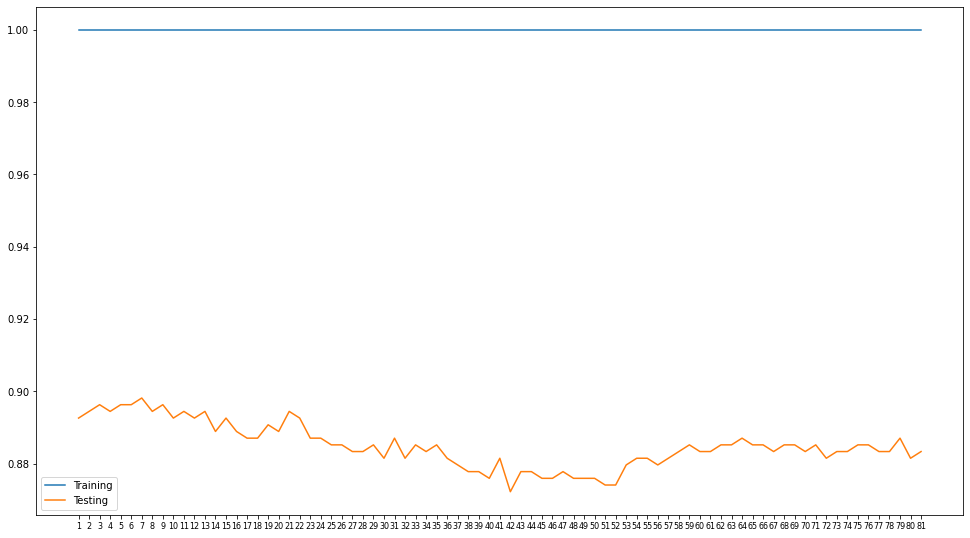

In [48]:
# Set up of visualization of the accuracy plot for the training and testing
# accuracy.
accuracy_forest = {'Training': training_accuracy,
                   'Testing': test_accuracy}
forest_accuracy = pd.DataFrame(accuracy_forest)
forest_accuracy['num trees'] = [f'{x}' for x in range(1, len(num_trees) + 1)]
ax = forest_accuracy.plot(xticks=forest_accuracy.index, figsize=(13, 7))
ax.set_xticklabels(forest_accuracy['num trees'], size=8)
plt.tight_layout(pad=-1)
plt.show()

### Kaggle submission

In [52]:
num_trees = list(range(100, 500 + 1, 5))
q = num_trees[idx]
state = 404923 
X_train, X_test, y_train, y_test = train_test_split(cleaned_data.iloc[:, :-1], target, 
                                                    test_size=0.3, stratify=target, 
                                                    random_state=state)
forest = RandomForestClassifier(criterion='entropy', n_estimators=q, random_state=state,
                                n_jobs=-1, max_features=4)
forest.fit(X_train, y_train)
train_score = forest.score(X_train, y_train)
test_score = forest.score(X_test, y_test)
training_accuracy.append(train_score)
test_accuracy.append(test_score)

print(f'\n*** Number of trees: {q}')
print(f'Training accuracy: {train_score:.5f}')
print(f'Test accuracy: {test_score:.5f}')


*** Number of trees: 130
Training accuracy: 1.00000
Test accuracy: 0.89815


In [53]:
# Read in the data which we are predicting for
test = pd.read_csv(r'assets\test.csv')

In [54]:
predictions = forest.predict(test.iloc[:, 1:]) # Predict the class label by the help of our model
my_submission = pd.DataFrame({'index': list(range(len(predictions))), 
                            'Drinkable': predictions}) # Convert the predictions into a DataFrame
my_submission.to_csv('submission11.csv', index=False) # which we then convert into a .csv file we can submit